In [1]:
import pandas as pd
import os
import re

In [2]:
models = []
for x in range(3):
    logDirectory = f"./lightning_logs"
    className = os.listdir(logDirectory)
    versionList = os.listdir('/'.join([logDirectory,className[x]]))
    versionList.sort(key=lambda x: int(re.search(r'\d+', x).group()))
    path = '/'.join([logDirectory,className[x],versionList[-1]])
    eventFile = '/'.join([path,[x for x in os.listdir(path) if r'events.out.tfevents' in x][-1]])
    models.append([className[x],eventFile])
models

[['EfficientNetModel',
  './lightning_logs/EfficientNetModel/version_4/events.out.tfevents.1725304737.LAPTOP-O6UKRVPK.22512.2'],
 ['ResnetModel',
  './lightning_logs/ResnetModel/version_1/events.out.tfevents.1725302007.LAPTOP-O6UKRVPK.22512.0'],
 ['VGGModel',
  './lightning_logs/VGGModel/version_32/events.out.tfevents.1725303428.LAPTOP-O6UKRVPK.22512.1']]

In [3]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

df=tflog2pandas(models[0][1])
#df=df[(df.metric != 'params/lr')&(df.metric != 'params/mm')&(df.metric != 'train/loss')] #delete the mentioned rows
# df.to_csv("output.csv")

In [4]:
valueTypes = df['metric'].unique()
valueTypes

array(['train_loss_step', 'train_acc_step', 'epoch', 'val_loss',
       'val_acc_F1', 'val_acc', 'train_loss_epoch', 'train_acc_epoch'],
      dtype=object)

In [56]:
df[df['metric'] == valueTypes[4]].value.to_numpy()

array([0.4577778 , 0.4577778 , 0.4577778 , 0.4577778 , 0.4577778 ,
       0.3604396 , 0.42045853, 0.48712522, 0.2817094 , 0.4577778 ,
       0.4577778 , 0.39231041, 0.38814816, 0.4577778 , 0.4577778 ,
       0.36296299, 0.36296299, 0.4577778 , 0.3483761 , 0.36296299,
       0.4577778 , 0.4577778 , 0.4577778 , 0.4577778 , 0.4577778 ])

In [12]:
def plotValue(models,value):
    score = []
    for x in models:
        df=tflog2pandas(x[1])
        score.append(df[df['metric'] == value].value.to_numpy())
    df = pd.DataFrame(score).transpose()
    df.columns = [x[0] for x in models]
    return df


In [13]:
loss = plotValue(models,valueTypes[3])
f1 = plotValue(models,valueTypes[4])
acc = plotValue(models,valueTypes[5])

<Axes: >

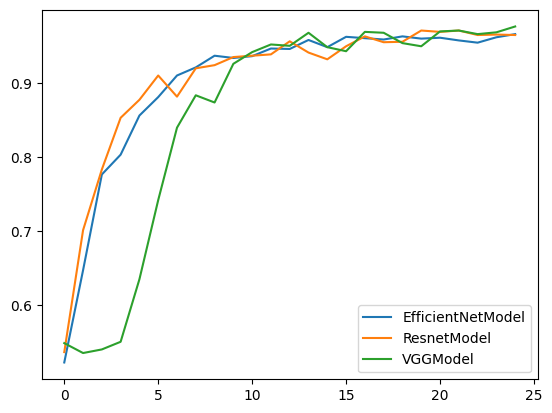

In [22]:
plotValue(models,valueTypes[-1]).plot()

<Axes: >

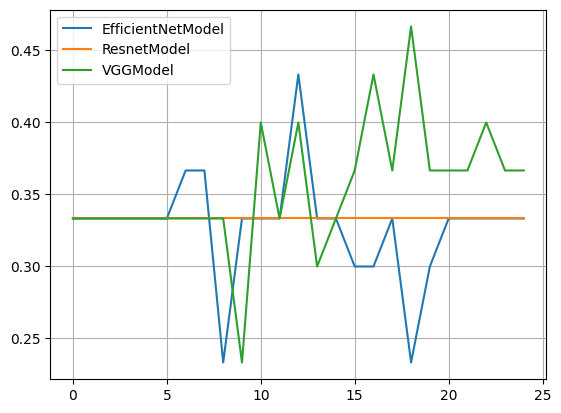

In [23]:
acc.plot(grid=True)

<Axes: >

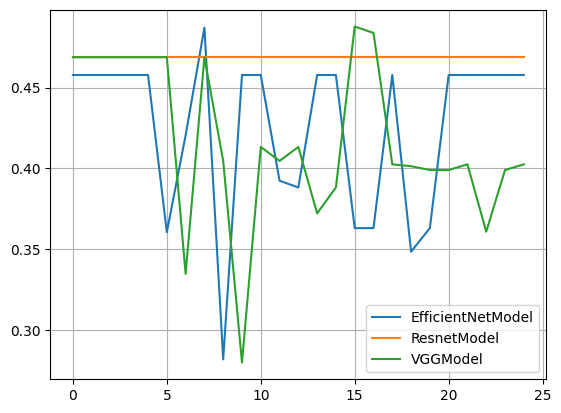

In [24]:
f1.plot(grid=True)